# Time Series Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os, warnings

warnings.filterwarnings("ignore")

In [2]:
path = os.path.join(os.getcwd(), 'datasets', 'stock_price', 'netflix_stock.csv')
df = pd.read_csv(path)
df.columns = df.columns.str.lower()
df.head()

,date,open,high,low,close,adj close,volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [3]:
# Convert to datetime
df["date"] = pd.to_datetime(df['date'])

# Set the date as the index
df.set_index("date", inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5540 entries, 2002-05-23 to 2024-05-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       5540 non-null   float64
 1   high       5540 non-null   float64
 2   low        5540 non-null   float64
 3   close      5540 non-null   float64
 4   adj close  5540 non-null   float64
 5   volume     5540 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 303.0 KB


In [5]:
# Count of values across the years
df.index.year.value_counts().sort_index()

date
2002    154
2003    252
2004    252
2005    252
2006    251
2007    251
2008    253
2009    252
2010    252
2011    252
2012    250
2013    252
2014    252
2015    252
2016    252
2017    251
2018    251
2019    252
2020    253
2021    252
2022    251
2023    250
2024    101
Name: count, dtype: int64

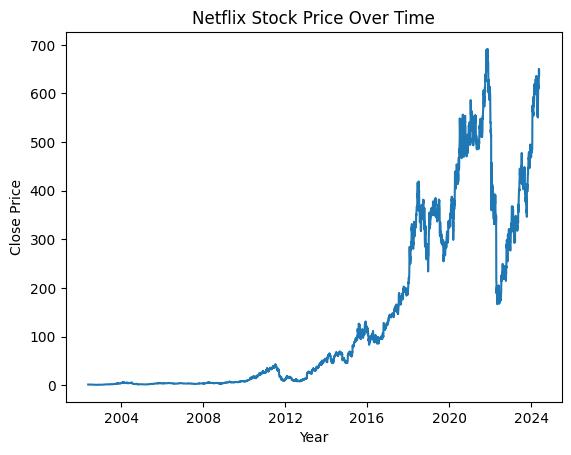

In [6]:
plt.plot(df.index, df["close"])
plt.ylabel("Close Price")
plt.xlabel("Year")
plt.title("Netflix Stock Price Over Time")
plt.show()

In [7]:
corr = df.corr(numeric_only=True)
corr

,open,high,low,close,adj close,volume
open,1.000000,0.999857,0.999858,0.999691,0.999691,-0.296650
high,0.999857,1.000000,0.999821,0.999863,0.999863,-0.295380
low,0.999858,0.999821,1.000000,0.999857,0.999857,-0.297963
close,0.999691,0.999863,0.999857,1.000000,1.000000,-0.296522
adj close,0.999691,0.999863,0.999857,1.000000,1.000000,-0.296522
volume,-0.296650,-0.295380,-0.297963,-0.296522,-0.296522,1.000000


# Autoregressive (AR) Model

Ths model assumes that the current value can be predicted using lagged variables (previous time steps).

- Lag represents the number of time units by which the series is shifted.
- Autocorrelation suggests if there is a high, low, or no relationship between the current and lag variables.
    - A ACF plot displays the autocorrelation coefficients at different lags.
    - The number of lag variables is often determined by the ACF plot.


Credit: [Link](https://www.geeksforgeeks.org/autoregressive-ar-model-for-time-series-forecasting/)

In [8]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.stats import boxcox

In [9]:
def add_lag(lag_n: int, col: str) -> None:
    """
    Creates a lag variable on a specified column.

    Params:
        lang_n (int): A number to lag the series by.
        col (str): The column to shift the series on.

    Return:
        None
    """
    df[f"lag_{lag_n}"] = df[col].shift(lag_n)

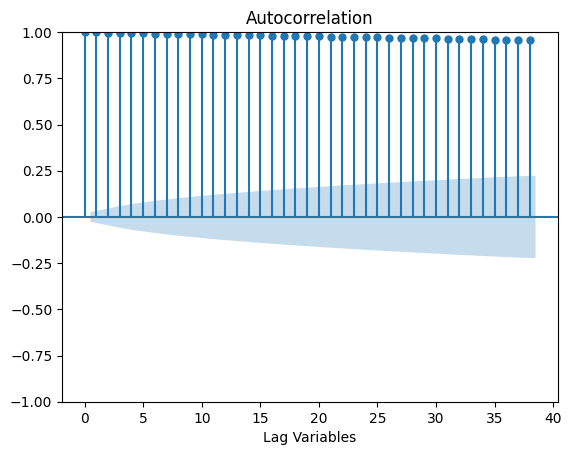

In [10]:
# Create a ACF plot using the closing prices
plot_acf(df["close"])
plt.xlabel("Lag Variables")
plt.show()

In [11]:
# Check the correlation with Lag = 1
df["close"].corr(df["close"].shift(40))

0.9782106506863765

In [12]:
# Split the data
train_size = int(0.75 * len(df))
train_data = df[:train_size]
test_data = df[train_size+1:]

y_train = train_data["close"]
y_test = test_data["close"]

In [13]:
# AR Model
lags = [i for i in range(1, 10)]
ar_model = AutoReg(y_train, lags=lags).fit()

In [14]:
# Make Predictions
y_pred = ar_model.predict(start=train_size+1, end=len(df)-1, dynamic=False)
y_pred

4156    269.103332
4157    269.119897
4158    271.897382
4159    272.090876
4160    272.629419
           ...    
5535    615.914317
5536    616.255268
5537    616.596385
5538    616.937668
5539    617.279117
Length: 1384, dtype: float64

In [15]:
# MAPE and MSE
mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"MAPE: {round(mape*100, 2)}%")
print(f"MSE: {round(mse, 2)}")

MAPE: 34.47%
MSE: 20299.82


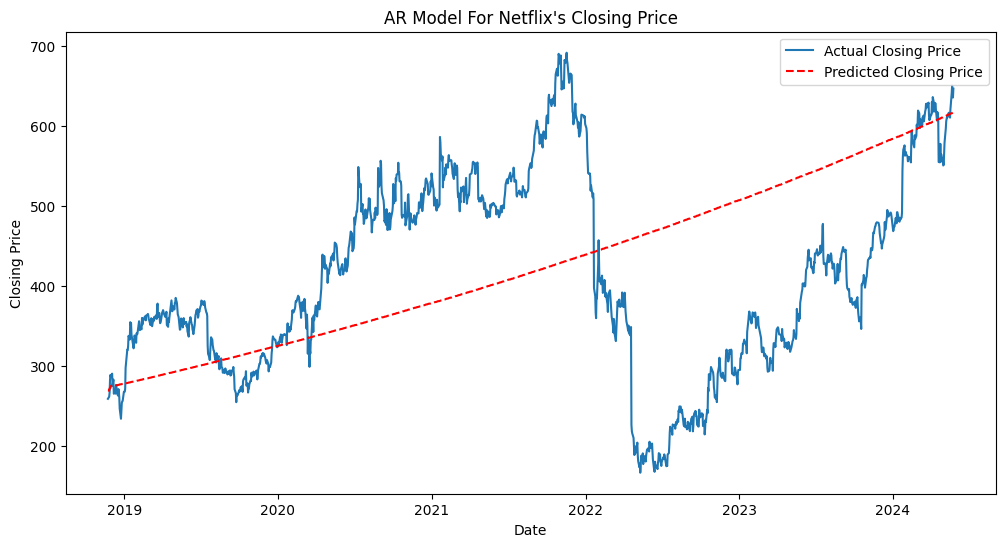

In [16]:
# Visualize actual and prediction
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Closing Price")
plt.plot(y_test.index, y_pred, c="r", linestyle="--", label="Predicted Closing Price")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("AR Model For Netflix's Closing Price")
plt.legend()
plt.show()

## Transform & Subset the Data
- Look at the last 90 days only.
- Determine if the data is stationary.
    - If not, transform the data using Box Cox
- ACF plot to determine lag variables.

In [17]:
# Copy data and look at the last 90 days
df_copy = df.copy()
ninety = df_copy[-90:]
ninety

,open,high,low,close,adj close,volume
date,,,,,,
2024-01-18,480.029999,485.769989,478.019989,485.309998,485.309998,4054400
2024-01-19,484.980011,485.670013,476.059998,482.950012,482.950012,5665600
2024-01-22,487.549988,489.799988,479.899994,485.709991,485.709991,5212300
2024-01-23,492.000000,498.959991,481.399994,492.190002,492.190002,15506000
2024-01-24,537.750000,562.500000,537.070007,544.869995,544.869995,26432800
...,...,...,...,...,...,...
2024-05-20,620.400024,644.369995,619.520020,640.820007,640.820007,3857900
2024-05-21,636.760010,650.880005,634.219971,650.609985,650.609985,2920200
2024-05-22,647.140015,649.250000,638.119995,640.469971,640.469971,2176200


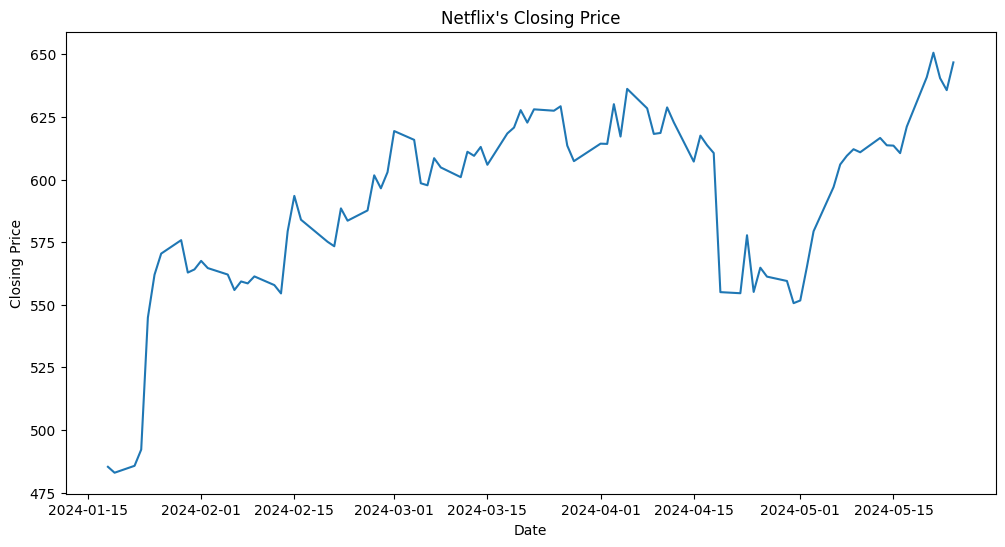

In [18]:
# Check if the closing price is stationary
plt.figure(figsize=(12, 6))
plt.plot(ninety.index, ninety["close"])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"Netflix's Closing Price")
plt.show()

In [19]:
# Transformation
bcox, lamb = boxcox(ninety["close"])
print(f"Lambda: {lamb}")

Lambda: 7.1202676940050456


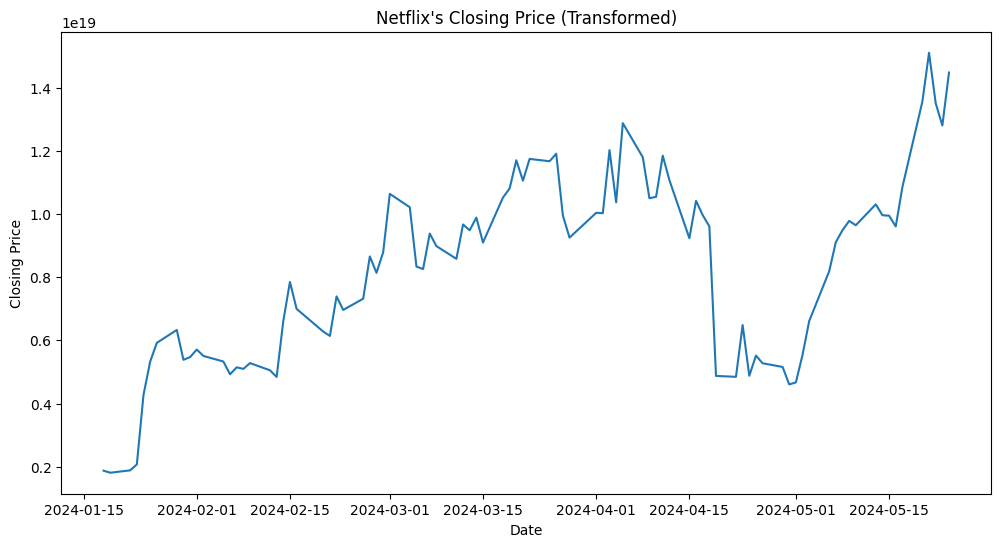

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(ninety.index, bcox)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title(f"Netflix's Closing Price (Transformed)")
plt.show()

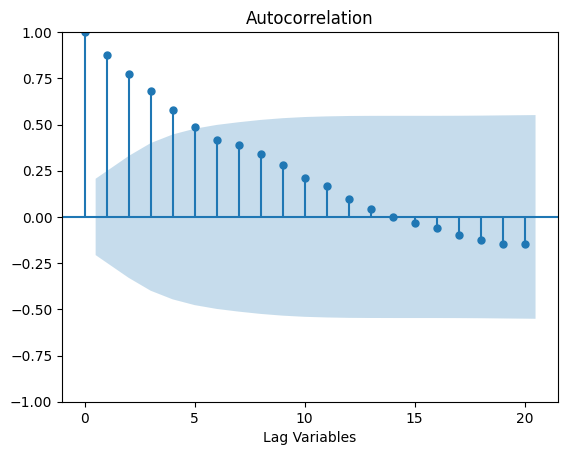

In [21]:
# Create a ACF plot using the transformed data
plot_acf(bcox)
plt.xlabel("Lag Variables")
plt.show()

In [22]:
# Split the new subset data
new_train_size = int(0.75 * len(ninety))
train_data = ninety[:new_train_size]
test_data = ninety[new_train_size:]

y_train = train_data["close"]
y_test = test_data["close"]

# Build the new model using lag the variables
lags = [i for i in range(1, 21)]
new_ar_model = AutoReg(y_train, lags=lags).fit()

new_y_preds = new_ar_model.predict(start=len(y_train), end=len(ninety)-1, dynamic=False)

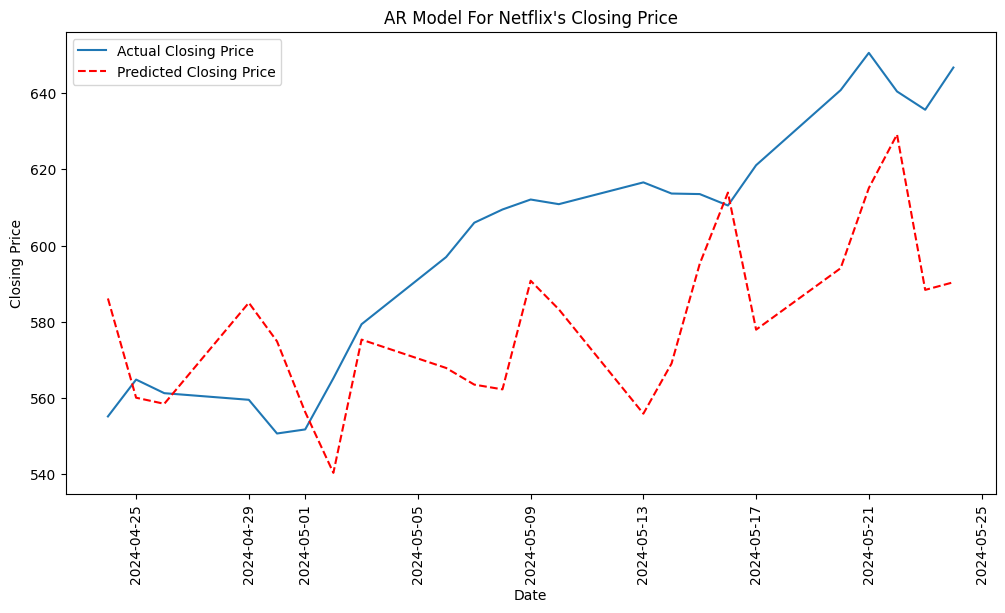

In [23]:
# Visualize actual and prediction
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Closing Price")
plt.plot(y_test.index, new_y_preds, c="r", linestyle="--", label="Predicted Closing Price")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.xticks(rotation=90)
plt.title("AR Model For Netflix's Closing Price")
plt.legend()
plt.show()

In [24]:
# MAPE and MSE
mape = mean_absolute_percentage_error(y_test, new_y_preds)
mse = mean_squared_error(y_test, new_y_preds)

print(f"MAPE: {round(mape*100, 2)}%")
print(f"MSE: {round(mse, 2)}")

MAPE: 4.68%
MSE: 1124.94
